# Sensor Metadata Analysis for the CUON Dataset

This notebook provides a complete analysis of the sensor identification methods for a specific station.
In particular, three different metadata sources are considered:

- WMO codes: the WMO codes are extracted from table at page A-398 of https://library.wmo.int/doc_num.php?explnum_id=10235 

- Schroeder's codes as can be found in XXX

- IGRA2 metadata that can be downloaded from https://www.ncei.noaa.gov/pub/data/igra/history/


WMO codes are available in the 

In [5]:
import os,sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from multiprocessing import Pool
from functools import partial

import h5py as h5

import plotly.graph_objects as go
import plotly.express as px

from multiprocessing import Pool
from functools import partial
import json

import urllib.request
pd.options.mode.chained_assignment = None 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


# Directory with the merged files 
merged = '/scratch/das/federico/MERGED_25FEB2022'

merged = '/users/staff/federico/GitHub/CEUAS_master_SEPTEMBER2021/CEUAS/CEUAS/public/postprocess/add_sensor/PROVA_newsensors_APRIL2022BugFix/'
#files_n = ['Lindenberg' , 'Payerne', 'Alaska']
#files = ['0-20001-0-10393_CEUAS_merged_v1.nc' , '0-20000-0-06610_CEUAS_merged_v1.nc' , '0-20000-0-70219_CEUAS_merged_v1.nc']


station = '0-20000-0-70350'
station_name = 'Kodiak (Alaska)'



## Reading the sensor_configuration table
This table contains is created by union of the Schoreder's and WMO's metadata. This table is confomr to the Common Data Model standards, and included in the CUON dataset files.

In [6]:
# sensor configuration
sensor_conf = pd.read_csv(os.getcwd()+'/data/sensor_configuration_all.csv', sep='\t',  index_col=0)

# add a converted column (to strings)
sensor_id_s = []
for s in sensor_conf.sensor_id.values:
    try:
        s = eval(s).decode('utf-8').replace(' ','')
    except:
        pass
    s = str(s)
    sensor_id_s.append(s)

sensor_conf['sensor_id'] = sensor_id_s

## IGRA2 Metadata
Reading the file from https://www.ncei.noaa.gov/pub/data/igra/history/igra2-metadata.txt

See https://www.ncei.noaa.gov/pub/data/igra/history/igra2-metadata-readme.txt for explanations.

The IGRA metadata consist of three principal types of radiosonde station
history information.

1. The primary source is Gaffen (1996):  Records from this source are 
   identified by an update date of 99/1996.

2. Updates to records for GUAN and RATPAC stations (Free et al. 2005) for 
   the period since Gaffen (1996):  Most of these records are identified 
   by a source attribution of Hammer (personal communication) and are 
   based on information received since 2004 through communication between 
   the NCDC GCOS Lead Center and GCOS focal points at Hydrological and 
   Meteorological Service Centers (HMSCs) in WMO member countries. 
   Additional sources of updated information include Joyce (personal 
   communication) and NOAA/NWS.

3. Events supplied by Steve Schroeder of Texas A&M University: 
   Identified by a source attribution of Schroeder (2007), these events 
   cover stations in the Russian Federation, India, Japan, China 
   (including Hong Kong and Taiwan), and Antarctic stations operated by 
   those countries.



In [7]:
if not os.path.isdir('data/igra2-metadata.txt'):
    url = 'https://www.ncei.noaa.gov/pub/data/igra/history/igra2-metadata.txt'
    urllib.request.urlretrieve(url, 'data/igra2-metadata.txt')

    
names = ['IGRAID', 'WMOID', "NAME", "NAMFLAG" , "LATITUDE", "LATFLAG" , "LONGITUDE", "LONFLAG", "ELEVATION", "ELVFLAG", "YEAR",
           "MONTH", "DAY", "HOUR","DATEIND","EVENT","ALTIND","BEFINFO","BEFFLAG","LINK","AFTINFO","AFTFLAG","REFERENCE","COMMENT","UPDCOM","UPDATE"] 

colspecs = [(0,11),(12,17),(18,48),(49,50),(50,60),(61,62),(63,72),(73,74),(75,81),(82,83),(84,88),
           (89,91),(92,94),(95,97),(98,99),(100,119),(120,122),(123,162),(163,164),(165,167),(168,207),(208,209),(210,234),(235,314),(315,346),(347,354)]



df = pd.read_fwf('data/igra2-metadata.txt', 
                colspecs=colspecs, names=names,
                )

def get_igra_metadata(station):
    """ Convert the Igra2 Metadata from plain txt into a dataframe,
    for the select station WMO id """
    
    """
    IGRAID         1- 11   Character
    WMOID         13- 17   Integer
    NAME          19- 48   Character
    NAMFLAG       50- 50   Character
    LATITUDE      52- 60   Real
    LATFLAG       62- 62   Character
    LONGITUDE     64- 72   Real
    LONFLAG       74- 74   Character
    ELEVATION     76- 81   Real
    ELVFLAG       83- 83   Character
    YEAR          85- 88   Integer
    MONTH         90- 91   Integer
    DAY           93- 94   Integer
    HOUR          96- 97   Integer
    DATEIND       99- 99   Integer
    EVENT        101-119   Character
    ALTIND       121-122   Character
    BEFINFO      124-163   Character
    BEFFLAG      164-164   Character
    LINK         166-167   Character
    AFTINFO      169-208   Character
    AFTFLAG      209-209   Character
    REFERENCE    211-235   Character
    COMMENT      236-315   Character
    UPDCOM       316-346   Character
    UPDDATE      348-354   Character
    """

    # Using read_fwf with fixed column widths 
    names = ['IGRAID', 'WMOID', "NAME", "NAMFLAG" , "LATITUDE", "LATFLAG" , "LONGITUDE", "LONFLAG", "ELEVATION", "ELVFLAG", "YEAR",
           "MONTH", "DAY", "HOUR","DATEIND","EVENT","ALTIND","BEFINFO","BEFFLAG","LINK","AFTINFO","AFTFLAG","REFERENCE","COMMENT","UPDCOM","UPDATE"] 

    colspecs = [(0,11),(12,17),(18,48),(49,50),(50,60),(61,62),(63,72),(73,74),(75,81),(82,83),(84,88),
           (89,91),(92,94),(95,97),(98,99),(100,119),(120,122),(123,162),(163,164),(165,167),(168,207),(208,209),(210,234),(235,314),(315,346),(347,354)]

    df = pd.read_fwf('data/igra2-metadata.txt', 
                colspecs=colspecs, names=names  )

    df = df.astype(str)
    wmos = [i if len(i) == 5 else '0'+i for i in df.WMOID]
 
    df['WMOID'] = wmos
    wmoid = station.split('-')[-1]
    #print(wmoid)
    stat = df.loc[df.WMOID == wmoid]
    #print(stat)
    
    # Extracting and converting dates 
    month = [i if len(i) == 2 else '0'+i for i in stat.MONTH]
    month = [m if int(m) <=12 else '01' for m in month]
    stat["MONTH"] = month
    stat["DATE"] = stat["YEAR"].astype(str) + stat["MONTH"].astype(str)
    stat["DATE"] = pd.to_datetime(stat['DATE'] , format='%Y%m' )

    
    update = stat[[ "EVENT","ALTIND","BEFINFO","BEFFLAG","LINK","AFTINFO","AFTFLAG" ]].agg(' , '.join, axis=1)
    
    u = [ ','.join(  [ v for v in c.split(',') if 'nan' not in v ]) for c in update  ]
    stat['UPDATE'] = u
    stat = stat[ ["DATE", "WMOID", "UPDATE", "REFERENCE", "COMMENT"] ]
    return stat

    
stat_igra2 = get_igra_metadata(station)
#stat_igra2

In [8]:

def get_sensor_id_comments(sensor_id, sensor_conf):
    """ Extracts the metadata realtive to a given sensor id from the sensor_configuration table """

    s = sensor_id

    # list placeholders
    sensors, description  = [], []

    d = sensor_conf[sensor_conf['sensor_id'] == s ]
    if d.empty:
        s = s.replace('.0', '').replace('.', '')
        if len(s) == 2 and int(s) != 80:
            s = '1' + s
        elif len(s) ==2 and int(s) == 80:
            s = '80'
        d = sensor_conf[sensor_conf['sensor_id'] == s ]

    try:
        com = d.comments.values[0]
    except:
        com = 'NA'        

    try:
        com = eval(com).decode('utf-8')
    except:
        pass

    return com




In [9]:
#get_sensor_id_comments('VDT', sensor_conf)

## Analyze A Specific Station

Here we analyze a specific station.
Reads data from the "/data" directory if data was already extracted in the past. 

Otherwise, the user must have access to the directory of the "merged"  files as indicated above.

In [10]:
def analyze_station(sensor_conf, station):
    
        
    def get_indices(data):
        data = data.reset_index()
        # find the indices where the sensor was replaced 
        indices = []
        last = ''
        for index, row in data.iterrows():
            sid = row.sensor_id
            #if sid =='nan':
            #    continue
            #print(index)
            if index ==0:
                indices.append(index)
                last = sid
            else:
                if sid == last:
                    continue
                else:
                    #print(sid , ' ' , last )
                    last = sid
                    #print(sid , ' ' , last )
                    indices.append(index)
        return indices
    
    # extracting station primary id 
    
    if not ( os.path.isfile('data/' + station + '_sch.csv') and os.path.isfile('data/' + station + '_wmo.csv')):
        
        print("Retrieving data from merged file")

        #file = [f for f in os.listdir(merged) if station in f and 'Sensor' not in f ][0]
        file = [f for f in os.listdir(merged) if station in f][0]

        station = file.split('/')[-1].split('_')[0]
        file = merged + '/' + file 

        f = h5.File(file, 'r')
        ts = f['recordtimestamp'][:]
        tsd = pd.to_datetime( ts, unit='s',  origin=pd.Timestamp('1900-01-01') )

        #index_minus = np.where(tsd <=  pd.Timestamp('1994-01-01')  )[0][-1]
        index_minus = 0   # change to start from a certain date onwards 
        
        #index_plus = np.where(tsd >  pd.Timestamp('1997-01-01')  )[0][0]
        index_plus = np.where(tsd <  pd.Timestamp('2013-01-01')  )[0][-1]


        # Extracting Schroeder 
        ind_obs_sch = list(f['recordindex'][:]) [index_minus:index_plus]
        i = np.take( f['observations_table']['sensor_id'][:].view('|S4') , ind_obs_sch) 
        ids_s = [s.decode('utf-8').replace('.0','').replace('.','') for s in i ]
        dic = {'date_time': tsd[index_minus:index_plus] , 'sensor_id': ids_s }

        data_sch = pd.DataFrame(dic)
        data_sch['value'] = 1

        # Extracting WMO
        ind_obs_wmo     = list(f['recordindex'][:]) [index_plus:]
        ind_obs_wmo_all = list(f['recordindex'][:]) # taking all WMOs
        
        
        wmoids = np.take(  f['observations_table']['sensor_id'][:].view('|S4') , ind_obs_wmo)
        wmoids = [s.decode('utf-8') for s in wmoids ]

        for s in np.unique(wmoids):
            print(s, '  ', type(s))
        
        dic_wmo = {'date_time':tsd[index_plus:] , 'sensor_id':wmoids }
        data_wmo = pd.DataFrame (dic_wmo)
        data_wmo['value'] = 2

        data_wmo.to_csv('data/' + station + '_wmo.csv' , sep = '\t') 
        data_sch.to_csv('data/' + station + '_sch.csv' , sep = '\t') 
            
        f.close()
            
    else:
        print("Loading existing data")
        data_wmo = pd.read_csv( 'data/' + station + '_wmo.csv' , sep = '\t')
        data_wmo['date_time'] = pd.to_datetime(data_wmo['date_time'] )

        data_sch = pd.read_csv('data/' + station + '_sch.csv' , sep = '\t') 
        data_sch['date_time'] = pd.to_datetime(data_sch['date_time'] )

        
    data_wmo['source'] = 'WMO'
    data_sch['source'] = 'SCH'

    # cleaning WMO data from nans 
    data_wmo_clean = data_wmo.loc[ (data_wmo.sensor_id != 'nan') & (data_wmo.sensor_id != '-922')].dropna( subset=['sensor_id'])
    data_wmo_clean.reset_index()
    
    #print(data_wmo_clean[data_wmo_clean.date_time >=  pd.Timestamp('1994-11-02') ][:20])
    
    indices_wmo_clean = get_indices(data_wmo_clean)
    #print(indices_wmo_clean)
    
    data_wmo_clean = data_wmo_clean.iloc[indices_wmo_clean]
    
    # getting only variation int he sensor_id indices 
    indices_sch = get_indices(data_sch)
    indices_wmo = get_indices(data_wmo)

    data_df = pd.concat( [data_sch.iloc[ list(indices_sch)], data_wmo. iloc[ list(indices_wmo)] ] )
    data_df_clean = pd.concat(  [data_sch.iloc[ list(indices_sch)], data_wmo_clean ]  ) # removed nans

    #unique_ids = np.unique(data['sensor_id'])
    comments = [ str(get_sensor_id_comments(str(i).replace(' ','').replace('.0',''), sensor_conf)) for i in data_df.sensor_id]

    data_df['comment'] = comments
    sid_clean = [str(i).replace('.0','')  for i in data_df.sensor_id]
    data_df['sensor_id'] = sid_clean    


    # Adding comments 
    for d in [data_df, data_df_clean]:
        comments = [ str(get_sensor_id_comments(str(i).replace(' ','').replace('.0',''), sensor_conf)) for i in d.sensor_id]
        d['comment'] = comments
        sid_clean = [str(i).replace('.0','')  for i in d.sensor_id]
        d['sensor_id'] = sid_clean    

        
    return data_sch, data_wmo, data_df, data_wmo_clean, data_df_clean 


In [74]:
# Extract all sensor data
data_sch, data_wmo, data_df, data_wmo_clean, data_df_clean = analyze_station(sensor_conf, station)

# Extract only unique entries
# Extract a small table with unqiue sensors and description 
sensors,ind = np.unique( data_df.sensor_id, return_index= True)
#ind
df_sensor = data_df.iloc[list(ind)] [['sensor_id', 'source', 'comment']]
#df_sensor


Loading existing data


,sensor_id,source,comment
227,-922,WMO,NA
657,111,WMO,"Sippican LMS6 w/Chip Thermistor, external boom mounted capacitance relative humidity sensor, and derived pressure from GPS height"
3491,124,WMO,Vaisala RS41/AUTOSONDE (Finland)
1,51,WMO,VIZ-B2 (United States)
43626,VU1,SCH,"VU1 Vaisala RS80-56H or RS80-56 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1995} 31313=43702^ (W3=37, T=038) <F=T1680AL,P=Ac,T=CB,U=A>"
45516,VU3,SCH,"VU3 Vaisala RS80-57H or RS80-57 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1998} 31313=45202^ (W3=52, T=039) (RDF, 1680+-3 MHz AM)"
0,ZH1,SCH,"ZH1 VIZ model 1292-410 NWS 1680 MHz baseline {1973}^ (W1=19 calls this VIZ 1292, T=427) NWS stock #J005 <F=V1680AB,P=A,T=TR(ML-405),U=C,W=Ra(WBRT or GMD-1)>"
32885,ZJA,SCH,"ZJA VIZ model 1392-510 NWS 1680 MHz Accu-Lok, new hygristor {1980}^ (T=001) NWS stock no. J031 <F=T1680AB,P=A,T=TR(ML-405),U=C,W=Ra(WBRT or GMD-1)>"
36837,ZKA,SCH,"ZKA VIZ model 1492-510 NWS 1680 MHz ART ""A"" Accu-Lok time sequenced {1986} 31313=01002^ (T=003,W3=10) 0.25 sec time sequenced <F=T1680AL,P=Ab,"
38556,ZKB,SCH,"ZKB VIZ model 1492-520 NWS 1680 MHz ART ""B"" Accu-Lok {1988} 31313=01102^ (T=004,W3=11,W2=28) NWS stock no. J060, 0.25 sec time sequenced <F=T1680AL,"


In [79]:
data_df_clean
#np.unique(data_wmo_clean.sensor_id)

,Unnamed: 0,date_time,sensor_id,value,source,comment
0,0,1941-12-02 23:00:00,ZH1,1,SCH,"ZH1 VIZ model 1292-410 NWS 1680 MHz baseline {1973}^ (W1=19 calls this VIZ 1292, T=427) NWS stock #J005 <F=V1680AB,P=A,T=TR(ML-405),U=C,W=Ra(WBRT or GMD-1)>"
32885,32885,1980-12-08 00:00:00,ZJA,1,SCH,"ZJA VIZ model 1392-510 NWS 1680 MHz Accu-Lok, new hygristor {1980}^ (T=001) NWS stock no. J031 <F=T1680AB,P=A,T=TR(ML-405),U=C,W=Ra(WBRT or GMD-1)>"
36837,36837,1986-05-14 00:00:00,ZKA,1,SCH,"ZKA VIZ model 1492-510 NWS 1680 MHz ART ""A"" Accu-Lok time sequenced {1986} 31313=01002^ (T=003,W3=10) 0.25 sec time sequenced <F=T1680AL,P=Ab,"
38556,38556,1988-10-01 00:00:00,ZKB,1,SCH,"ZKB VIZ model 1492-520 NWS 1680 MHz ART ""B"" Accu-Lok {1988} 31313=01102^ (T=004,W3=11,W2=28) NWS stock no. J060, 0.25 sec time sequenced <F=T1680AL,"
43626,43626,1995-10-19 20:00:00,VU1,1,SCH,"VU1 Vaisala RS80-56H or RS80-56 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1995} 31313=43702^ (W3=37, T=038) <F=T1680AL,P=Ac,T=CB,U=A>"
43627,43627,1995-10-20 00:00:00,ZKB,1,SCH,"ZKB VIZ model 1492-520 NWS 1680 MHz ART ""B"" Accu-Lok {1988} 31313=01102^ (T=004,W3=11,W2=28) NWS stock no. J060, 0.25 sec time sequenced <F=T1680AL,"
43651,43651,1995-11-01 00:00:00,VU1,1,SCH,"VU1 Vaisala RS80-56H or RS80-56 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1995} 31313=43702^ (W3=37, T=038) <F=T1680AL,P=Ac,T=CB,U=A>"
45516,45516,1998-06-01 00:00:00,VU3,1,SCH,"VU3 Vaisala RS80-57H or RS80-57 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1998} 31313=45202^ (W3=52, T=039) (RDF, 1680+-3 MHz AM)"
0,0,2012-12-31 12:00:00,VU3,2,WMO,"VU3 Vaisala RS80-57H or RS80-57 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1998} 31313=45202^ (W3=52, T=039) (RDF, 1680+-3 MHz AM)"
1,1,2013-01-01 00:00:00,51,2,WMO,VIZ-B2 (United States)


## Data Summary 

### Schroeder's and WMO's summary table

In [81]:
data_df_clean

,Unnamed: 0,date_time,sensor_id,value,source,comment
0,0,1941-12-02 23:00:00,ZH1,1,SCH,"ZH1 VIZ model 1292-410 NWS 1680 MHz baseline {1973}^ (W1=19 calls this VIZ 1292, T=427) NWS stock #J005 <F=V1680AB,P=A,T=TR(ML-405),U=C,W=Ra(WBRT or GMD-1)>"
32885,32885,1980-12-08 00:00:00,ZJA,1,SCH,"ZJA VIZ model 1392-510 NWS 1680 MHz Accu-Lok, new hygristor {1980}^ (T=001) NWS stock no. J031 <F=T1680AB,P=A,T=TR(ML-405),U=C,W=Ra(WBRT or GMD-1)>"
36837,36837,1986-05-14 00:00:00,ZKA,1,SCH,"ZKA VIZ model 1492-510 NWS 1680 MHz ART ""A"" Accu-Lok time sequenced {1986} 31313=01002^ (T=003,W3=10) 0.25 sec time sequenced <F=T1680AL,P=Ab,"
38556,38556,1988-10-01 00:00:00,ZKB,1,SCH,"ZKB VIZ model 1492-520 NWS 1680 MHz ART ""B"" Accu-Lok {1988} 31313=01102^ (T=004,W3=11,W2=28) NWS stock no. J060, 0.25 sec time sequenced <F=T1680AL,"
43626,43626,1995-10-19 20:00:00,VU1,1,SCH,"VU1 Vaisala RS80-56H or RS80-56 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1995} 31313=43702^ (W3=37, T=038) <F=T1680AL,P=Ac,T=CB,U=A>"
43627,43627,1995-10-20 00:00:00,ZKB,1,SCH,"ZKB VIZ model 1492-520 NWS 1680 MHz ART ""B"" Accu-Lok {1988} 31313=01102^ (T=004,W3=11,W2=28) NWS stock no. J060, 0.25 sec time sequenced <F=T1680AL,"
43651,43651,1995-11-01 00:00:00,VU1,1,SCH,"VU1 Vaisala RS80-56H or RS80-56 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1995} 31313=43702^ (W3=37, T=038) <F=T1680AL,P=Ac,T=CB,U=A>"
45516,45516,1998-06-01 00:00:00,VU3,1,SCH,"VU3 Vaisala RS80-57H or RS80-57 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1998} 31313=45202^ (W3=52, T=039) (RDF, 1680+-3 MHz AM)"
0,0,2012-12-31 12:00:00,VU3,2,WMO,"VU3 Vaisala RS80-57H or RS80-57 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1998} 31313=45202^ (W3=52, T=039) (RDF, 1680+-3 MHz AM)"
1,1,2013-01-01 00:00:00,51,2,WMO,VIZ-B2 (United States)


### IGRA2 summary table

In [82]:
stat_igra2

,DATE,UPDATE,value,date_time,comment,sensor_id,source
15745,1961-10-01,"CHANGE RH SENSOR , LITHIUM CHLORIDE HYGRISTOR , to , CARBON HYGRISTOR",3,1961-10-01,"CHANGE RH SENSOR , LITHIUM CHLORIDE HYGRISTOR , to , CARBON HYGRISTOR",IGRA2 METADATA,IGRA2
15746,1962-01-01,"CHANGE GROUND EQUIP , AN/GMD-1A , to , AN/GMD-1B",3,1962-01-01,"CHANGE GROUND EQUIP , AN/GMD-1A , to , AN/GMD-1B",IGRA2 METADATA,IGRA2
15747,1980-12-01,"CHANGE RH SENSOR , CARBON HYGRISTOR , to , NEW CARBON HYGRISTOR",3,1980-12-01,"CHANGE RH SENSOR , CARBON HYGRISTOR , to , NEW CARBON HYGRISTOR",IGRA2 METADATA,IGRA2
15748,1986-05-01,"CHANGE COMPUTER , MINI-COMPUTER , to , MINI-ART 2 SYSTEM",3,1986-05-01,"CHANGE COMPUTER , MINI-COMPUTER , to , MINI-ART 2 SYSTEM",IGRA2 METADATA,IGRA2
15749,1988-10-01,"CHANGE SONDE MODEL , VIZ ACCU-LOK UNSPECIFIED , to , VIZ B 1492-520 NWS 1680 MHZ",3,1988-10-01,"CHANGE SONDE MODEL , VIZ ACCU-LOK UNSPECIFIED , to , VIZ B 1492-520 NWS 1680 MHZ",IGRA2 METADATA,IGRA2
15750,1989-11-01,"CHANGE COMPUTER , MINI-ART 2 SYSTEM , ? , to , MICRO-ART SYSTEM VERSION UNSPECIFIED",3,1989-11-01,"CHANGE COMPUTER , MINI-ART 2 SYSTEM , ? , to , MICRO-ART SYSTEM VERSION UNSPECIFIED",IGRA2 METADATA,IGRA2
15751,1992-12-01,"USING SONDE MODEL , I1 , VIZ UNSPECIFIED",3,1992-12-01,"USING SONDE MODEL , I1 , VIZ UNSPECIFIED",IGRA2 METADATA,IGRA2
15752,1993-10-01,"CHANGE DATA CUTOFF , MISC. ALGORITHM , to , CORRECTED ALGORITHM",3,1993-10-01,"CHANGE DATA CUTOFF , MISC. ALGORITHM , to , CORRECTED ALGORITHM",IGRA2 METADATA,IGRA2
15753,1993-10-01,"CHANGE GRAVITY VAL. , 9.8 METERS PER SECOND SQUARED , to , 9.80665 METERS PER SECOND SQUARED",3,1993-10-01,"CHANGE GRAVITY VAL. , 9.8 METERS PER SECOND SQUARED , to , 9.80665 METERS PER SECOND SQUARED",IGRA2 METADATA,IGRA2
15754,1993-10-01,"CHANGE RH ALGORITHM , DEW POINT DEPRESSION = 30 C IF RH < 20% , to , NO CUTOFFS",3,1993-10-01,"CHANGE RH ALGORITHM , DEW POINT DEPRESSION = 30 C IF RH < 20% , to , NO CUTOFFS",IGRA2 METADATA,IGRA2


In [83]:
# convert stat_igra2 to data_df format and concatenate 

stat_igra2
stat_igra2 = stat_igra2[["DATE","UPDATE"] ]


stat_igra2.DATE
stat_igra2['value'] = 3
stat_igra2['date_time'] = stat_igra2['DATE']
stat_igra2['comment'] = stat_igra2['UPDATE']

stat_igra2['sensor_id'] = 'IGRA2 METADATA'
stat_igra2['source'] = 'IGRA2'

# Select only IGRA2 metadata relative to "SONDE" events 

updates = list(stat_igra2.comment.values)

ind = [ updates.index(i) for i in updates if 'SONDE' in i ]

stat_igra2_sonde = stat_igra2.iloc[ind]

data_df_clean = pd.concat([data_df_clean, stat_igra2_sonde])
data_df = pd.concat([data_df, stat_igra2])

In [84]:
stat_igra2_sonde

,DATE,UPDATE,value,date_time,comment,sensor_id,source
15749,1988-10-01,"CHANGE SONDE MODEL , VIZ ACCU-LOK UNSPECIFIED , to , VIZ B 1492-520 NWS 1680 MHZ",3,1988-10-01,"CHANGE SONDE MODEL , VIZ ACCU-LOK UNSPECIFIED , to , VIZ B 1492-520 NWS 1680 MHZ",IGRA2 METADATA,IGRA2
15751,1992-12-01,"USING SONDE MODEL , I1 , VIZ UNSPECIFIED",3,1992-12-01,"USING SONDE MODEL , I1 , VIZ UNSPECIFIED",IGRA2 METADATA,IGRA2
15756,1995-11-01,"CHANGE SONDE MODEL , VIZ B 1492-520 NWS 1680 MHZ , to , VAISALA RS80-56H NWS SOLAR/IR CORR",3,1995-11-01,"CHANGE SONDE MODEL , VIZ B 1492-520 NWS 1680 MHZ , to , VAISALA RS80-56H NWS SOLAR/IR CORR",IGRA2 METADATA,IGRA2


## Time series of the sensor changes for the station 

Making a time series with the changes in the sensor id types, or relevant IGRA2 metadata. 

Each dot corresponds to a specific sonde type as indicated by the colors in the legend, both for the WMO and the Schroeder's data.
The complete list with the description of the instruments is provided below.

Green dots and green vertical lines represent IGRA2 metadata relative to the station, which might include also sensor information, but non exclusively.



In [85]:
data_df_clean

,Unnamed: 0,date_time,sensor_id,value,source,comment,DATE,UPDATE
0,0.0,1941-12-02 23:00:00,ZH1,1,SCH,"ZH1 VIZ model 1292-410 NWS 1680 MHz baseline {1973}^ (W1=19 calls this VIZ 1292, T=427) NWS stock #J005 <F=V1680AB,P=A,T=TR(ML-405),U=C,W=Ra(WBRT or GMD-1)>",NaT,NaN
32885,32885.0,1980-12-08 00:00:00,ZJA,1,SCH,"ZJA VIZ model 1392-510 NWS 1680 MHz Accu-Lok, new hygristor {1980}^ (T=001) NWS stock no. J031 <F=T1680AB,P=A,T=TR(ML-405),U=C,W=Ra(WBRT or GMD-1)>",NaT,NaN
36837,36837.0,1986-05-14 00:00:00,ZKA,1,SCH,"ZKA VIZ model 1492-510 NWS 1680 MHz ART ""A"" Accu-Lok time sequenced {1986} 31313=01002^ (T=003,W3=10) 0.25 sec time sequenced <F=T1680AL,P=Ab,",NaT,NaN
38556,38556.0,1988-10-01 00:00:00,ZKB,1,SCH,"ZKB VIZ model 1492-520 NWS 1680 MHz ART ""B"" Accu-Lok {1988} 31313=01102^ (T=004,W3=11,W2=28) NWS stock no. J060, 0.25 sec time sequenced <F=T1680AL,",NaT,NaN
43626,43626.0,1995-10-19 20:00:00,VU1,1,SCH,"VU1 Vaisala RS80-56H or RS80-56 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1995} 31313=43702^ (W3=37, T=038) <F=T1680AL,P=Ac,T=CB,U=A>",NaT,NaN
43627,43627.0,1995-10-20 00:00:00,ZKB,1,SCH,"ZKB VIZ model 1492-520 NWS 1680 MHz ART ""B"" Accu-Lok {1988} 31313=01102^ (T=004,W3=11,W2=28) NWS stock no. J060, 0.25 sec time sequenced <F=T1680AL,",NaT,NaN
43651,43651.0,1995-11-01 00:00:00,VU1,1,SCH,"VU1 Vaisala RS80-56H or RS80-56 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1995} 31313=43702^ (W3=37, T=038) <F=T1680AL,P=Ac,T=CB,U=A>",NaT,NaN
45516,45516.0,1998-06-01 00:00:00,VU3,1,SCH,"VU3 Vaisala RS80-57H or RS80-57 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1998} 31313=45202^ (W3=52, T=039) (RDF, 1680+-3 MHz AM)",NaT,NaN
0,0.0,2012-12-31 12:00:00,VU3,2,WMO,"VU3 Vaisala RS80-57H or RS80-57 1680 MHz RDF H-Humicap NWS radiosonde, pressure cell {1998} 31313=45202^ (W3=52, T=039) (RDF, 1680+-3 MHz AM)",NaT,NaN
1,1.0,2013-01-01 00:00:00,51,2,WMO,VIZ-B2 (United States),NaT,NaN


In [111]:
def make_time_series(data_df, station_name, label = ''):
    #filter date
    #data_df = data_df.loc[data_df.date_time <= pd.Timestamp('1995-01-01')]

    # converts categorical char values for sensor ids to integer values (on y-axis in the plots)
    data_df['values'] = pd.factorize( data_df.sensor_id)[0]


    fig = px.scatter(data_df, x="date_time", y="values", color="sensor_id",
                    hover_name="sensor_id", hover_data=["comment"]
                    )

    fig.update_layout(title='Sensors Time Series - ' + station_name + ' ' + label)
    #fig.update_yaxes( ticktext= ['Schroeder', 'WMO', 'IGRA2'],
    #                  tickvals= [1,2,3])

    fig.update_layout(width= 1800, height = 400)

    fig.update_layout(
        xaxis_title="Date of Sensor Replacement",
        yaxis_title="Sensor Metadata",
        legend_title="Sensor ID",
        font=dict(
            size=16,
            color="black"
        )
    )

    fig.update_traces(marker=dict(size=14,
                                  line=dict(width=2,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))




    for d in stat_igra2.date_time:
        fig.add_vline(x=d, line_width=3, line_dash="dash", line_color="green")



    fig.update_layout(hovermode="x unified")

    fig.update_layout(
    yaxis = dict(
    tickfont = dict(size=16)))

    return fig
# fig = make_time_series(data_df, station_name) 
# fig.show()

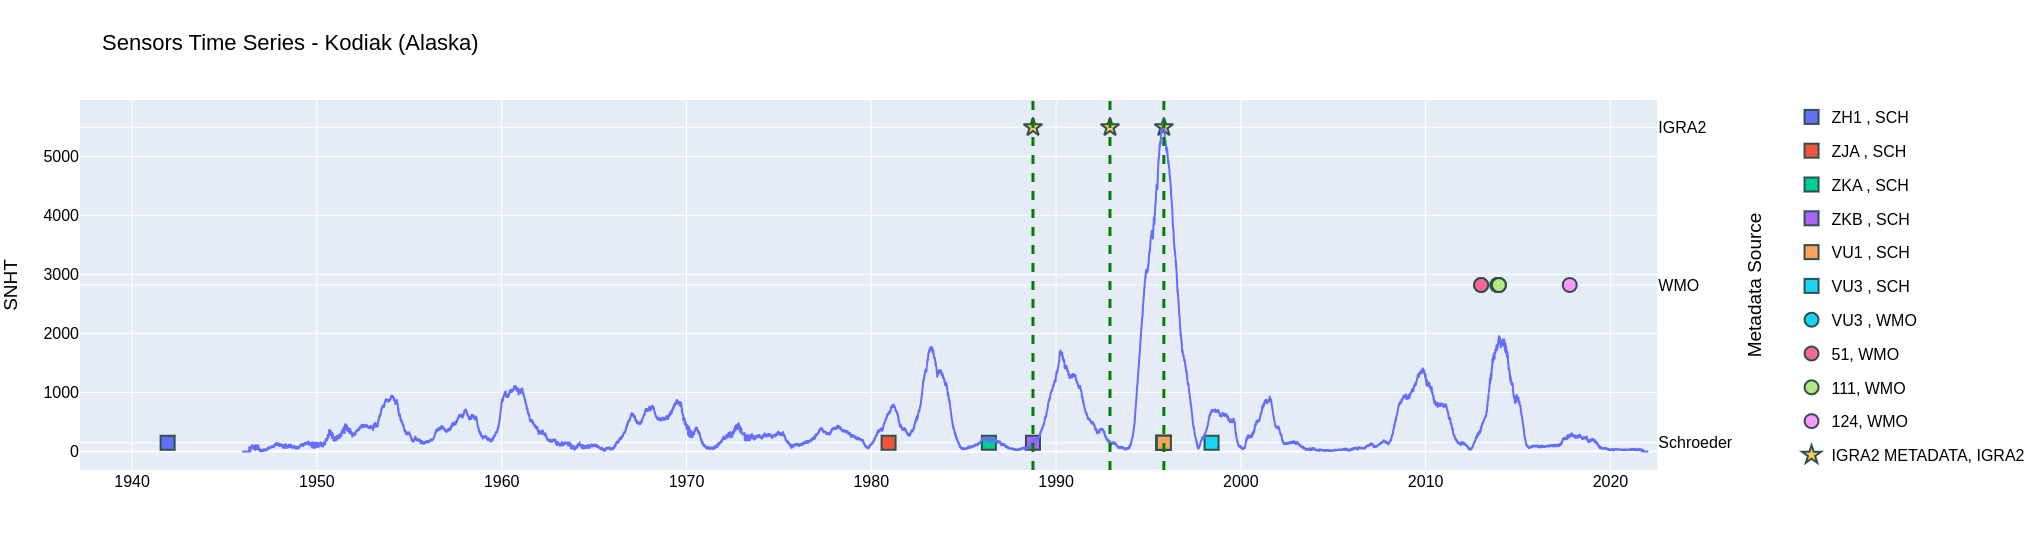

In [109]:
import json
from plotly.subplots import make_subplots

def make_time_series_2(data_df, station_name, label = ''):
    #filter date
    #data_df = data_df.loc[data_df.date_time <= pd.Timestamp('1995-01-01')]
    from plotly.subplots import make_subplots

    with open('/mnt/users/staff/leo/python/CEUAS/CEUAS/public/adjust/feedbackmerged070350_breakanalysis.json') as f:
        d=json.load(f)
        time = pd.to_datetime(d['days_since_1900'] , unit='d', origin=pd.Timestamp('1900-01-01') )
    
    snht = pd.DataFrame( {'time': time , 'snht':d['tsasum'] } )
    
    symbols = {"IGRA2":'star', "WMO":'circle', "SCH":'square'}

    #markers = {"IGRA2":0, "WMO":17, "SCH":22}
    #data_df['symbols'] = [markers[i] for i in data_df.source ]
    
    #print(data_df['symbols'])
    # Create figure with secondary y-axis
    subfig = make_subplots(specs=[[{"secondary_y": True}]])
    fig1 = px.line(snht, x="time", y="snht")
    fig2 = px.scatter(data_df, x="date_time", y="value", color="sensor_id",
                    hover_name="sensor_id", hover_data=["comment"],
                    symbol="source",
                    symbol_map= symbols )
    
    fig2.update_traces(yaxis="y2")



    

    subfig.add_traces(fig1.data + fig2.data)
    subfig.layout.xaxis.title=""
    subfig.layout.yaxis.title="SNHT"
    subfig.layout.yaxis2.title="Metadata Source"
    # recoloring is necessary otherwise lines from fig und fig2 would share each color
    # e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
    subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
    #subfig.show()

    subfig.update_layout(title='Sensors Time Series - ' + station_name + ' ' + label)

    subfig.update_layout(width= 1800, height = 550)


    subfig.update_traces(marker=dict(size=14,
                                  line=dict(width=2,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))



    igra2 = data_df.loc[data_df.source == 'IGRA2']
    for d in igra2.date_time:
        subfig.add_vline(x=d, line_width=3, line_dash="dash", line_color="green")



    subfig.update_layout(hovermode="x unified")

    subfig.update_layout(
    yaxis = dict(
    tickfont = dict(size=16)),
    font=dict(
        size=16,
        color="black"
        )
    )

    subfig.update_yaxes( ticktext= ['Schroeder', 'WMO', 'IGRA2'],
                      tickvals= [1,2,3], secondary_y=True )
        
    return subfig


fig = make_time_series_2(data_df_clean, station_name) 
fig.show()

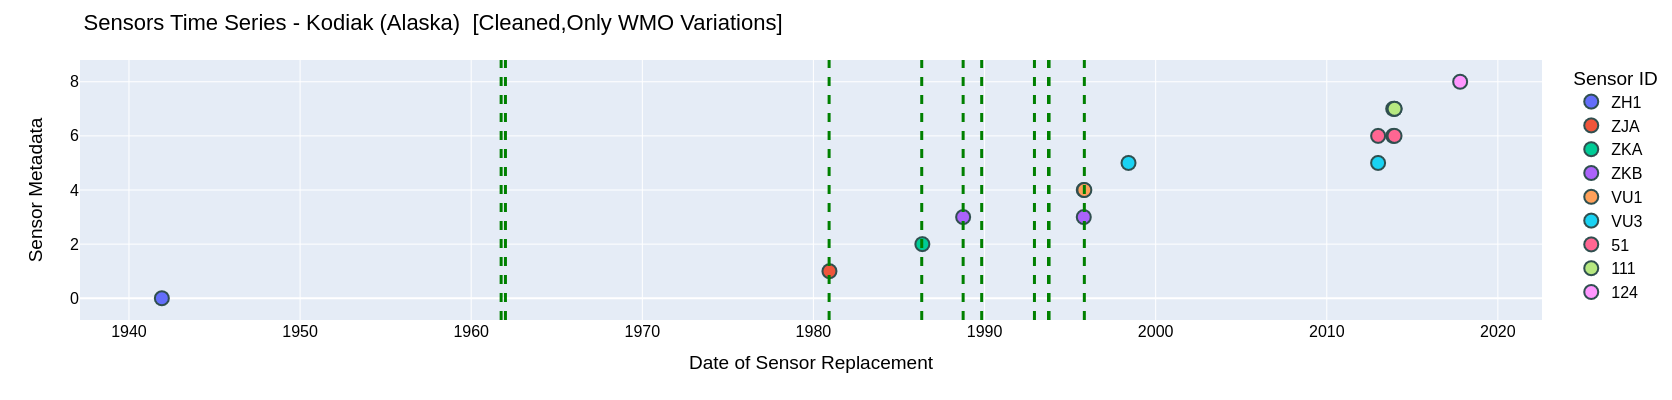

In [19]:
fig = make_time_series(data_df_clean, station_name, label=' [Cleaned,Only WMO Variations]') 
fig.show()

In [131]:
nans_ind = np.where( (data_df.sensor_id != 'nan') & (data_df.sensor_id != '-922') &  (data_df.source != 'IGRA2')  )[0]
data_sensor_clean = data_df.iloc[nans_ind]
data_sensor_clean_tab = data_sensor_clean.drop_duplicates(subset=['sensor_id'])

## Summary table of the sensor

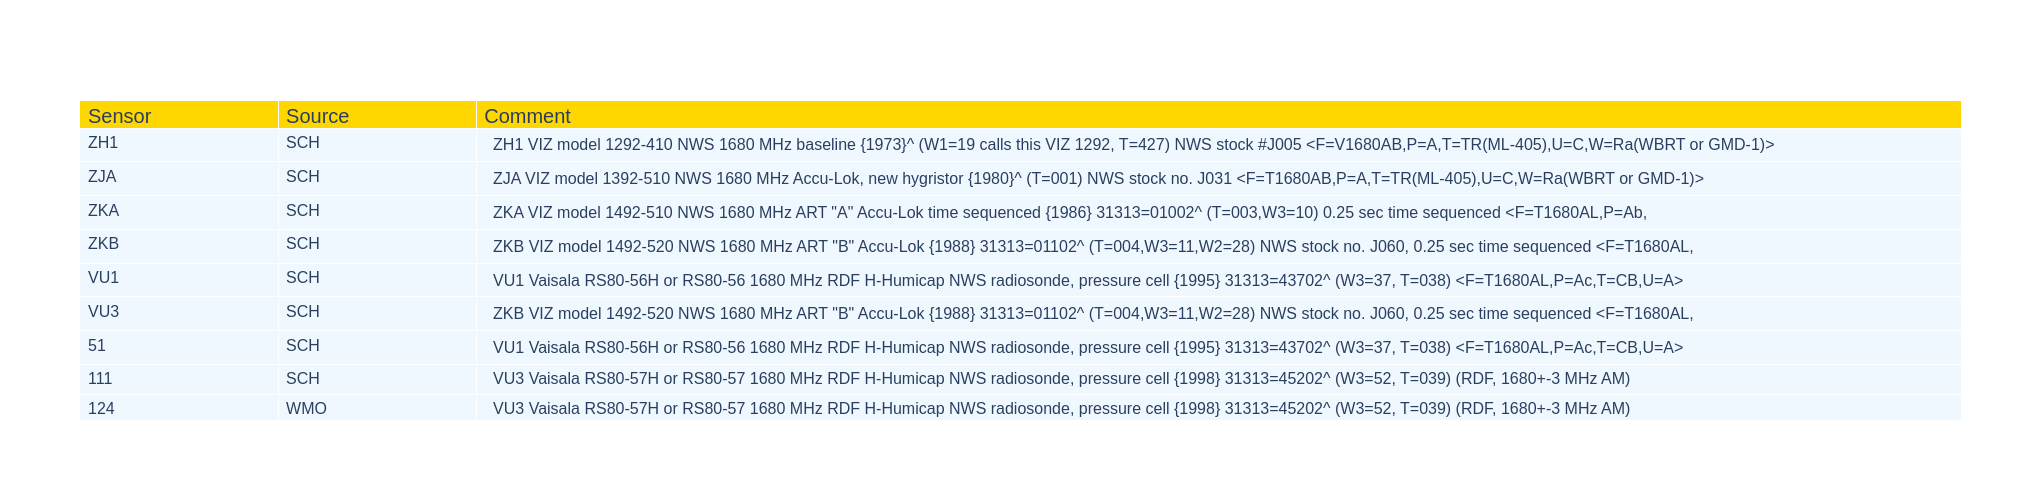

In [132]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['Sensor','Source', 'Comment']),
                fill_color='gold',
                align='left',
                font_size=20),
    columnwidth = [40,40,300],
    cells=dict(values=[data_sensor_clean_tab.sensor_id, data_sensor_clean.source, data_sensor_clean.comment],
               fill_color='aliceblue',
               align='left',
               font_size=16,
               height=30
              )),
])

fig.update_layout(width=1900, height=50*len(df_sensor))

fig.show()

## Counts and time series of the WMO sensors

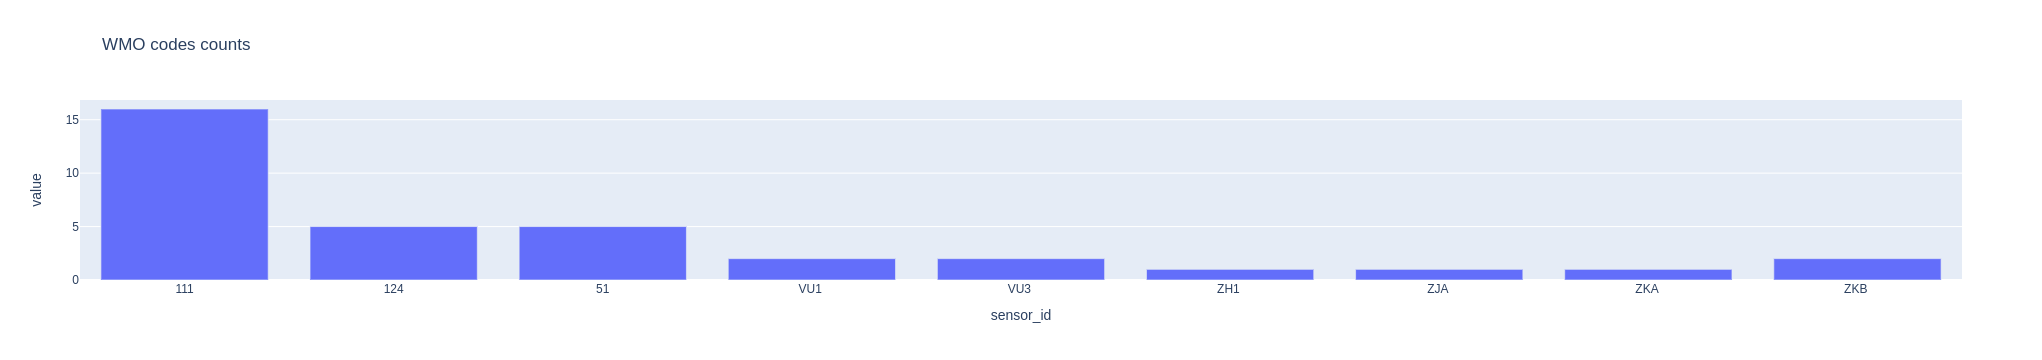

In [133]:
df = data_sensor_clean.groupby(["sensor_id"]).count()
fig = px.bar(df, x=df.index, y='value', title = 'WMO codes counts')
fig.show()